# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Varun Chandra Shekar
#### Student ID: s4017549

Date: 12th May 2024

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy
* sklearn
* itertools
* nltk
## Introduction
- In this notebook I have answered two tasks i.e. Task 2 and Task 3, I have first loaded all the libraries which are required by both the tasks, then I have loaded the necessary files required to handle both the tasks, i.e. vocab.txt, cleanedjob.txt and labels.csv.
- For task 2, there are two questions I have first calculated the count feature vector for the bag of words model using the CountVectorizer library and the fit_transform function.
- After calculating the vector, I have written function called checker to check whether the words are getting counted properly with respect to the tokenized description.
- I have chosen the word2vec model as my embeddin model, I am first training the model with google-news-300 dataset, and then after training the model, I am using that model to calculate the unweighted vector of the tokenized description, I have then plotted this graph using the tsne technique.
- I have then calculated the weighted tf-idf vector using the tf-idf vector that I generated from the initial vocabulary, with the vocabulary generated from the model that I trained with google-news-300. I have written the function wordweight to calculate the weight of each word and then wrote a function weightedvecs to generate the weighted tf-idf vector.
- I have then saved the countfeatures genrated from the bag of words model in count_vectors.txt.
- In task 3, I have used the logistic regression model to test all the three vectors and calculated the model's accuaracy.
- Then I extracted the title from the cleanedjob.txt and tokenized the title values, I then used the pre-trained word2vec model to extract the vector of the title and passed it through a logistic regression model to check the accuracy of it.
- Finally I combined both the title and description vectors to check the accuracy of the model.


## Importing libraries 

In [1]:
#I have imported all the necessary libraries required for this task.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from itertools import chain
from nltk.corpus import stopwords
import numpy as np
from nltk.probability import *
import logging
from pprint import pprint as print
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import nltk
import seaborn as sns

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

### Loading files

In [2]:
#I am first loading the labels file and storing it into a dataframe called df, 
#the column Category gives information of labels associated with the respective tokenized descritpion.
#I have done this because I need the labels to perform logistic regressions later.
import pandas as pd
df = pd.read_csv('labels.csv')
df.head()

Category                                            tokened
0  Accounting_Finance  accountant, partqualified, south, east, london...
1  Accounting_Finance  hedge, funds, london, recruiting, fund, accoun...
2  Healthcare_Nursing  exciting, arisen, establish, provider, elderly...
3  Accounting_Finance  expanding, recruiting, junior, trainee, broker...
4  Healthcare_Nursing  rgn, nurses, hospitals, fulltime, part, swiis,...

                    tokened
Category                   
Accounting_Finance      191
Engineering             231
Healthcare_Nursing      198
Sales                   156


<Axes: xlabel='Category'>

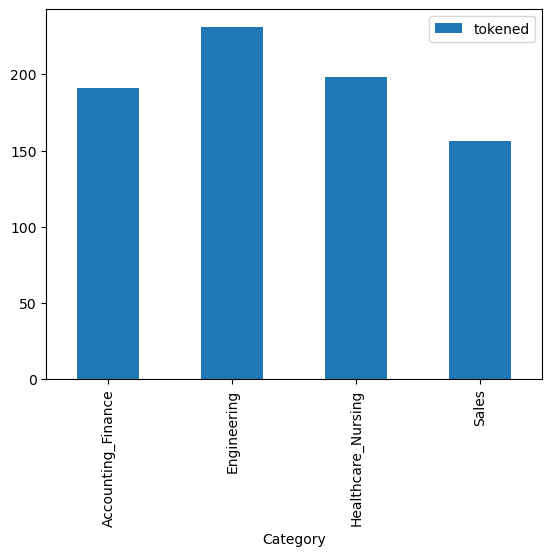

In [3]:
#I am printing the stats of the labels, i.e. the count of the respective labels
statslabel = df.groupby('Category').count()
print(statslabel)
statslabel.plot.bar(ylim=0)

In [4]:
#I am reading the vocab.txt and storing it into a dictionary called vocab.
vfile = "vocab.txt"
vocab = {}
with open(vfile, "r", encoding = 'utf-8') as file:
    lines = file.readlines()
    for line in lines:
        word, index = line.strip().split(":")
        vocab[word] = int(index)
print(vocab)

{'aap': 0,
 'aaron': 1,
 'aat': 2,
 'abb': 3,
 'abenefit': 4,
 'aberdeen': 5,
 'abi': 6,
 'abilities': 7,
 'abreast': 8,
 'abroad': 9,
 'absence': 10,
 'absolute': 11,
 'ac': 12,
 'aca': 13,
 'academic': 14,
 'academy': 15,
 'acca': 16,
 'accept': 17,
 'acceptable': 18,
 'acceptance': 19,
 'accepted': 20,
 'access': 21,
 'accessible': 22,
 'accident': 23,
 'accommodates': 24,
 'accommodation': 25,
 'accomplished': 26,
 'accordance': 27,
 'account': 28,
 'accountabilities': 29,
 'accountability': 30,
 'accountable': 31,
 'accountancy': 32,
 'accountant': 33,
 'accountants': 34,
 'accounting': 35,
 'accounts': 36,
 'accreditation': 37,
 'accredited': 38,
 'accruals': 39,
 'accuracy': 40,
 'accurate': 41,
 'accurately': 42,
 'achievable': 43,
 'achieve': 44,
 'achieved': 45,
 'achievement': 46,
 'achievements': 47,
 'achiever': 48,
 'achieving': 49,
 'acii': 50,
 'acquired': 51,
 'acquisition': 52,
 'acquisitions': 53,
 'act': 54,
 'acting': 55,
 'action': 56,
 'actions': 57,
 'actionscri

In [5]:
#I am reading the cleanedjob.txt which I saved in the first task to extact the tokenized description and the webindexes of the file.
def readpre(filename):
    preprocess = []
    with open(filename,"r",encoding = 'utf-8') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Pre-Processed Description:'):
                desc= line.split(':', 1)[1].strip()
                preprocess.append(desc) 
    return preprocess
#I am saving the tokenized description as "tk_description".
tk_description = readpre('cleanedjob.txt')

In [6]:
#I am extracting the webindexes of the respective descriptions
def extractindex(filename):
    webindexes = []
    with open(filename, "r", encoding = 'utf-8') as file:
        for line in file:
            if 'Webindex:' in line:
                webindex = line.split('Webindex:')[1].strip().split(',')[0]
                webindexes.append(webindex)
    return webindexes
#I am extracting the webindex and storing it as webindexes.
webindexes = extractindex('cleanedjob.txt')

In [7]:
len(webindexes)

776

In [8]:
#I am converting it to tokens for further calculation of vectors.
tk_tokens = [desc.split() for desc in tk_description]

In [9]:
#I am checking whether the tokens were split properly.
tk_tokens

[['accountant',
  'partqualified',
  'south',
  'east',
  'london',
  'manufacturing',
  'requirement',
  'accountant',
  'permanent',
  'modern',
  'offices',
  'south',
  'east',
  'london',
  'credit',
  'control',
  'purchase',
  'ledger',
  'daily',
  'collection',
  'debts',
  'phone',
  'letter',
  'email',
  'handling',
  'ledger',
  'accounts',
  'handling',
  'accounts',
  'negotiating',
  'payment',
  'terms',
  'cash',
  'reconciliation',
  'accounts',
  'adhoc',
  'administration',
  'duties',
  'person',
  'ideal',
  'previous',
  'credit',
  'control',
  'capacity',
  'possess',
  'exceptional',
  'customer',
  'communication',
  'part',
  'fully',
  'qualified',
  'accountant',
  'considered'],
 ['hedge',
  'funds',
  'london',
  'recruiting',
  'fund',
  'accountant',
  'paying',
  'outstanding',
  'west',
  'end',
  'report',
  'head',
  'fund',
  'accounting',
  'number',
  'fund',
  'accountants',
  'senior',
  'fund',
  'accountants',
  'responsible',
  'fund',
  '

### Count Vector(Bag Of Words Model)

In [10]:
#I am calculating the count vector for the given vocabulary using the CountVectorizer Function and fit_transform function
cVectorizer = CountVectorizer(analyzer="word",vocabulary=vocab)
countfeatures = cVectorizer.fit_transform(tk_description)
countfeatures.shape

(776, 5168)

In [11]:
#I am checking whether the vector is correctly calculated or not
countfeatures[0]

<1x5168 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [12]:
#This is a checker function to compare the correct count of the words to the respective description of the file.
def checker(dfeature, vocab):
    featurenames = cVectorizer.get_feature_names_out()
    for i, desc in enumerate(tk_description):
        print(f"Description {i+1}: {desc}")
        print("Vector Representation: ")
        vector_repr = ""
        for word, value in zip(featurenames, dfeature[i].toarray().flatten()):
            if value > 0:
                vector_repr += f"{word}:{value} "
        print(vector_repr)
        print("\n------------------------------")

In [13]:
#Passing the checker function to check the values and if the words are getting counted to the respective description.
checker(countfeatures, vocab)

('Description 1: accountant partqualified south east london manufacturing '
 'requirement accountant permanent modern offices south east london credit '
 'control purchase ledger daily collection debts phone letter email handling '
 'ledger accounts handling accounts negotiating payment terms cash '
 'reconciliation accounts adhoc administration duties person ideal previous '
 'credit control capacity possess exceptional customer communication part '
 'fully qualified accountant considered')
'Vector Representation: '
('accountant:3 accounts:3 adhoc:1 administration:1 capacity:1 cash:1 '
 'collection:1 communication:1 considered:1 control:2 credit:2 customer:1 '
 'daily:1 debts:1 duties:1 east:2 email:1 exceptional:1 fully:1 handling:2 '
 'ideal:1 ledger:2 letter:1 london:2 manufacturing:1 modern:1 negotiating:1 '
 'offices:1 part:1 partqualified:1 payment:1 permanent:1 person:1 phone:1 '
 'possess:1 previous:1 purchase:1 qualified:1 reconciliation:1 requirement:1 '
 'south:2 terms:1 ')

('add:1 agency:1 board:1 close:1 comm:1 commercial:3 competitor:1 '
 'conjunction:1 contacts:1 determined:1 develop:1 digital:1 director:4 '
 'division:1 eligible:1 expanding:1 experienced:1 forming:1 great:1 grow:1 '
 'head:1 ideal:1 ideally:1 increase:1 individual:1 keen:1 levels:2 liaise:1 '
 'manage:1 managing:2 member:1 online:2 order:1 organised:1 partnerships:2 '
 'player:1 portal:1 present:1 prestigious:1 previous:1 relevant:1 '
 'responsibility:1 responsible:1 revenue:1 salestarget:1 senior:1 shopping:1 '
 'significant:1 similar:1 solid:1 strategic:1 successfully:1 title:1 turn:1 ')
'\n------------------------------'
('Description 640: maintenance technicians summary main duties duties '
 'concerned installation repair maintenance machinery assembly line equipment '
 'duties concerned installation repair maintenance factory buildings ancillary '
 'equipment fittings supervision trainees daily reporting completed spare '
 'parts stock control reporting requirements cleanliness 

### Logging

In [14]:
#Tracking events and display information through logging
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.INFO)

### Word2Vec Model

Reason I am chosing Word2Vec Model:
To my understanding of the model the word2vec model is that it helps in effectively captures the semantic relationship and contextual nuances of employment-related terminology. I am trying to extract meaningful patterns from the job descriptions using this model.

### Unweighted Vector Representation

In [15]:
#I am pre-training the word2vec model with the help of google-news-300 data, downloaded from the gensim library
import gensim.downloader as api
pretrained_wv = api.load('word2vec-google-news-300')

2024-05-20 12:45:18,034: INFO : loading projection weights from /Users/varunchandrashekar/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2024-05-20 12:45:38,517: INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/varunchandrashekar/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-05-20T12:45:38.517772', 'gensim': '4.3.2', 'python': '3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'load_word2vec_format'}


In [16]:
print(pretrained_wv)

In [17]:
#I am checking the size of the pre-trained vector, on whether I have got 300 words.
pretrained_wv.vector_size

300

In [18]:
#I am printing the first five words that was generated from the downloaded google-news-300.
for index, word in enumerate(pretrained_wv.index_to_key):
    if index == 5:
        break
    print(f"{index}: {word}")

'0: </s>'
'1: in'
'2: for'
'3: that'
'4: is'


In [19]:
#I am first storing it to a list, which has the sum of word vectors for each document.
#I am then storing the words vectors temporarily in list called temp.
#Finally I am returing a dataframe of the calculated vectors.
def docvectors(wv, tk_txts):
    docvec = []
    for tokens in tk_txts:
        temp = [] 
        for word in tokens:
            if word in wv:
                temp.append(wv[word])  
        if temp:
            docvec.append(np.sum(temp, axis=0))
        else:
            docvec.append(np.zeros(wv.vector_size))
    return pd.DataFrame(docvec)

In [20]:
# NOTE this can take some time to finish running, I am calculating the unweighted vector.
unweighted = docvectors(pretrained_wv,tk_tokens)

In [21]:
#I am checking if the values are getting calculated correctly.
unweighted

0          1         2         3         4         5          6    \
0     0.752701   1.535202 -0.959763  0.145927  0.337387  2.264709  -0.689301   
1     0.209290   1.938171  2.122955  2.340660  0.675140 -0.609497   0.570648   
2    -4.973572  -0.125425  0.039459 -0.555878 -3.108154 -1.404053   3.422550   
3    -1.147881   2.647675 -0.749817  1.750244 -1.853699 -1.820675   0.404980   
4    -3.558548   0.628075 -1.552185  4.043530 -4.518372 -3.065369   5.994431   
..         ...        ...       ...       ...       ...       ...        ...   
771  -1.171585   0.356247 -2.587921  1.562500  1.974548 -1.667938  -0.853729   
772 -13.155685  11.580147  2.545387  4.106238 -8.895008 -1.403893  13.774372   
773 -12.229085  11.071129 -6.650787  5.133041 -8.758530  4.797577   5.005447   
774  -2.310516   3.108437 -3.534607  2.994080 -6.828430  6.026917   3.726868   
775  -2.033630   2.571005 -1.316864 -1.493958 -3.488831 -3.093567   0.020187   

           7          8          9    ...        290        291        292  \
0    -4.422668   3.918457   2.599548  ...  -5.441772   2.289948  -3.585842   
1    -5.657169   7.982697  -0.905609  ...  -4.684105   6.460129  -3.356812   
2    -5.592590   4.306976  -1.724815  ...  -5.470856   1.695343  -5.014526   
3    -2.240421   1.846344   1.815089  ...  -2.885651   2.926819  -2.497742   
4    -5.978271   5.829208   3.333984  ...  -5.320404   2.991020  -7.160202   
..         ...        ...        ...  ...        ...        ...        ...   
771  -3.452375   3.323151   2.463654  ...  -2.448109   1.801331  -6.928955   
772 -11.792810  14.842012  13.298004  ... -21.869080  12.759827 -20.667328   
773 -23.535778  12.826080  -9.296745  ... -13.845177  10.660278 -25.591263   
774  -8.312987   4.839661   1.103645  ...  -3.318394   5.163715  -7.229324   
775  -9.376461   6.717424   6.111275  ...  -9.266235   3.980457  -9.406418   

           293       294       295        296       297        298       299  
0     0.160706 -1.608154  0.472916  -0.450588 -1.391571  -0.381226 -3.150208  
1     2.719025  0.201538 -0.678894   1.273987  0.717865   0.105591  0.246948  
2     0.349869 -0.272217  1.538353  -0.347199 -4.104675   0.352936 -2.616699  
3     0.520813 -0.972656  0.596741   3.073410  0.373614  -0.096527  0.310362  
4    -0.161396 -0.633545  5.454086  -1.107452 -1.175232  -0.436832 -4.710098  
..         ...       ...       ...        ...       ...        ...       ...  
771  -0.489977  2.563080 -0.278393   4.001038 -0.896729   0.433044 -2.833752  
772  10.899315 -7.270081  9.067268   3.877106 -2.802891   0.969384 -9.961752  
773   6.729279 -0.571627  8.072754  13.324265  1.863449  11.017811  3.090748  
774   0.514893  0.363617  2.166382  -0.457535  1.816195   3.475182 -2.744751  
775   0.892982  1.049011 -4.184769   4.836379 -0.179688   1.579361 -0.754822  

[776 rows x 300 columns]

In [22]:
#I am checkingif there are any null values that are present in the vector.
unweighted.isna().any().sum()

0

In [23]:
#I am writting a function to plot the vector based on t-sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def pTSNE(labels,features):
    cat = sorted(labels.unique())
    ssize = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=ssize, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['red', 'green', 'blue', 'orange']
    for i in range(0,len(cat)):
        points = projected_features[(labels[indices] == cat[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=cat[i])
    plt.title("Feature vector for each job description.",
              fontdict=dict(fontsize=10))
    plt.legend()
    plt.show()

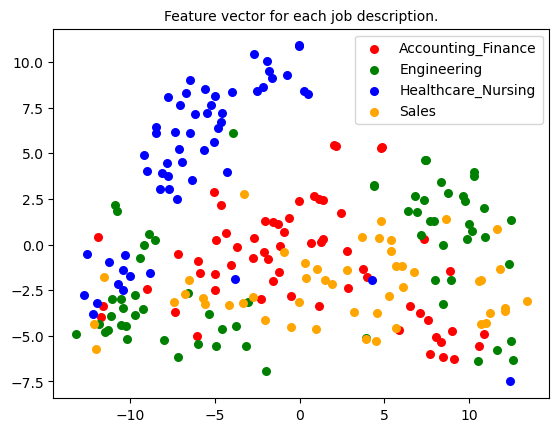

In [24]:
#I am plotting the graph for featured vector, I am first converting it to a numpy array and then using the pTSNE function to plot the graph
try:
    features = unweighted.to_numpy()
except:
    features = unweighted
pTSNE(df['Category'],features)

### Weighted TF-IDF Vector

In [25]:
#I am initalizing the tfidf vector to calculate the 
from sklearn.feature_extraction.text import TfidfVectorizer
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab)
tfidf_features = tVectorizer.fit_transform(tk_description)
tfidf_features.shape

(776, 5168)

In [26]:
tfidf_features

<776x5168 sparse matrix of type '<class 'numpy.float64'>'
	with 62166 stored elements in Compressed Sparse Row format>

In [27]:
#I am saving the generated tfidf_features in tVector.txt file to use it for further calculations in the weighted tf-idf weighted calculation
def tvectorFile(dataf,f):
    num = dataf.shape[0] # 
    outf = open(f, 'w') 
    for a_ind in range(0, num): 
        for f_ind in dataf[a_ind].nonzero()[1]:
            value = dataf[a_ind][0,f_ind] 
            outf.write("{}:{} ".format(f_ind,value))
        outf.write('\n')
    outf.close()
tvectorFile(tfidf_features, "tVector.txt")

In [28]:
#I am generating the vocabulary dictionary in index,word format, that is why I am re-reading the file again to generate in that format.
def vocindex(fname):
    with open(fname) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] 
    return {int(vi[1]):vi[0] for vi in voc_Ind}


# Generates the w_index:word dictionary
fname = 'vocab.txt' # path for the vocabulary
vdict = vocindex(fname)
vdict

{0: 'aap',
 1: 'aaron',
 2: 'aat',
 3: 'abb',
 4: 'abenefit',
 5: 'aberdeen',
 6: 'abi',
 7: 'abilities',
 8: 'abreast',
 9: 'abroad',
 10: 'absence',
 11: 'absolute',
 12: 'ac',
 13: 'aca',
 14: 'academic',
 15: 'academy',
 16: 'acca',
 17: 'accept',
 18: 'acceptable',
 19: 'acceptance',
 20: 'accepted',
 21: 'access',
 22: 'accessible',
 23: 'accident',
 24: 'accommodates',
 25: 'accommodation',
 26: 'accomplished',
 27: 'accordance',
 28: 'account',
 29: 'accountabilities',
 30: 'accountability',
 31: 'accountable',
 32: 'accountancy',
 33: 'accountant',
 34: 'accountants',
 35: 'accounting',
 36: 'accounts',
 37: 'accreditation',
 38: 'accredited',
 39: 'accruals',
 40: 'accuracy',
 41: 'accurate',
 42: 'accurately',
 43: 'achievable',
 44: 'achieve',
 45: 'achieved',
 46: 'achievement',
 47: 'achievements',
 48: 'achiever',
 49: 'achieving',
 50: 'acii',
 51: 'acquired',
 52: 'acquisition',
 53: 'acquisitions',
 54: 'act',
 55: 'acting',
 56: 'action',
 57: 'actions',
 58: 'action

In [29]:
#I am calculating the word weight of each word based on the generated tf-idf vector and the vocabulary generated from the tokenized description.
def wordweight(tfname, vdict):
    tfidf_weights = [] 
    
    with open(tfname) as tVecf: 
        tVectors = tVecf.read().splitlines()
    for tv in tVectors: 
        tv = tv.strip()
        weights = tv.split(' ')
        weights = [w.split(':') for w in weights]
        wordweight_dict = {vdict[int(w[0])]:w[1] for w in weights}
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

tfname = 'tVector.txt'
wordweights = wordweight(tfname, vdict)

In [30]:
#Checking the wordweights
wordweights

[{'terms': '0.1308521762366382',
  'south': '0.20612279476719383',
  'requirement': '0.1249811292375601',
  'reconciliation': '0.14183179957804745',
  'qualified': '0.07821166567368464',
  'purchase': '0.13660500449583682',
  'previous': '0.08245826258151072',
  'possess': '0.10970668693524623',
  'phone': '0.11922830097836144',
  'person': '0.09046563231320097',
  'permanent': '0.08174449947711492',
  'payment': '0.13824362212075778',
  'partqualified': '0.173326820839609',
  'part': '0.07189780182251101',
  'offices': '0.11518385918795168',
  'negotiating': '0.15985275501239027',
  'modern': '0.13218581222143622',
  'manufacturing': '0.09726367012728679',
  'london': '0.16839249893971672',
  'letter': '0.12835773375082868',
  'ledger': '0.27321000899167364',
  'ideal': '0.08802432794046589',
  'handling': '0.24392130714952515',
  'fully': '0.1061919231001392',
  'exceptional': '0.12835773375082868',
  'email': '0.07884175705492424',
  'east': '0.20514266820633364',
  'duties': '0.082

In [31]:
#I am finally generating the weighted vectors based on the pretrained model, wordweights and the tokenized description
def weightedvecs(embeddings, tfidf, docs):
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        tf_weights = [float(tfidf[i].get(term, 0.)) for term in valid_keys]
        assert len(valid_keys) == len(tf_weights)
        weighted = [embeddings[term] * w for term, w in zip(valid_keys, tf_weights)]
        docvec = np.vstack(weighted)
        docvec = np.sum(docvec, axis=0)
        vecs[i,:] = docvec
    return vecs
weightedvectors = weightedvecs(pretrained_wv, wordweights, tk_tokens)

In [32]:
#Checking the weighted vectors
weightedvectors

array([[ 0.40638176,  0.32099706, -0.20472217, ..., -0.34826139,
        -0.19133288, -0.42731032],
       [ 0.83990562,  0.50701874,  1.18341959, ...,  0.11899151,
        -0.49857962, -0.34340513],
       [-0.49331525,  0.18903188,  0.07917877, ..., -1.22994053,
         0.28230104, -0.58456933],
       ...,
       [-2.09581327,  1.52784061, -0.94615775, ...,  0.14255729,
         1.7248925 ,  1.25669384],
       [ 0.01132933,  0.34981903, -0.6350866 , ...,  0.55008024,
         0.65203965, -0.32084349],
       [-0.28180438,  0.09079882, -0.22296759, ...,  0.18920794,
         0.15184812, -0.02109518]])

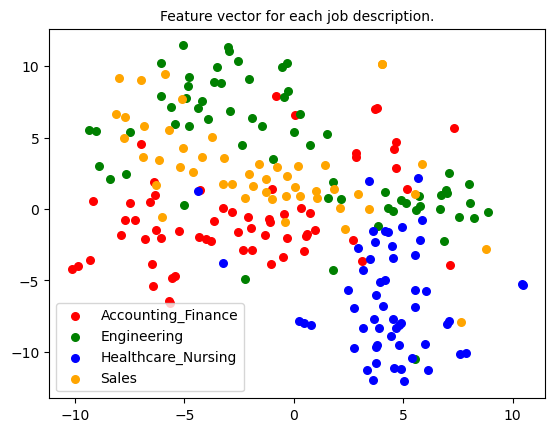

In [33]:
#I am plotting tsne for weighted vectors.
features = weightedvectors
pTSNE(df['Category'],features)

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [34]:
#I am saving the countvectors based on the description and indexes generated in the first vocabulary as count_vectors.txt
def countvectors(webindexes, count_features, output_file):
    with open(output_file, 'w') as file:
        for webindex, counts in zip(webindexes, count_features):
            counts_str = ', '.join([f"{idx}:{count}" for idx, count in zip(counts.indices, counts.data)])
            file.write(f"#{webindex}, {counts_str}\n")
output_file = 'count_vectors.txt'
countvectors(webindexes, countfeatures, output_file)

## Task 3. Job Advertisement Classification

### Question 1

### Model Evaluation Of All The Generated Vectors

In [35]:
#I am setting the seed
seed = 0

In [36]:
#This is for count vectors of bag of words model:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(countfeatures, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 1000, random_state=seed)
model.fit(X_train, y_train)
print("This is the model accuracy for CountVector:")
model.score(X_test, y_test)

'This is the model accuracy for CountVector:'


0.8793774319066148

In [37]:
#I am using the confusion matrix to evaluate the accuracy of the classification based on the model:
predictedlabel = model.predict(X_test)
confusionmatrix = confusion_matrix(y_test, predictedlabel)
confusionmatrix

array([[57,  4,  2,  5],
       [ 1, 69,  3,  5],
       [ 1,  3, 55,  0],
       [ 1,  5,  1, 45]])

Text(0.5, 23.52222222222222, 'Predicted')

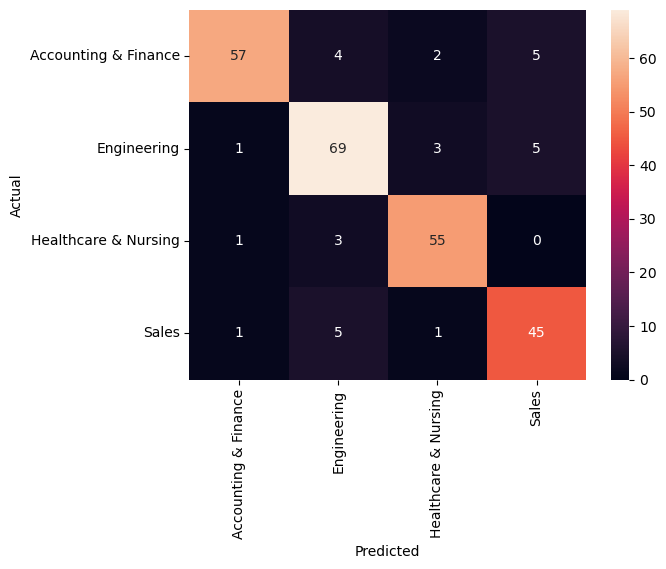

In [38]:
#I am plotting a heatmap to generate the confusion matrix
%matplotlib inline
jcategories = ['Accounting & Finance', 'Engineering', 'Healthcare & Nursing', 'Sales'] 
sns.heatmap(confusionmatrix, annot=True, fmt='d',
            xticklabels=jcategories, yticklabels=jcategories)

plt.ylabel('Actual')
plt.xlabel('Predicted')

In [39]:
#This is for weighted(tf-idf) vector
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(weightedvectors, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 1000, random_state=seed)
model.fit(X_train, y_train)
print("This is the model accuracy for Weighted TF-IDF vector:")
model.score(X_test, y_test)

'This is the model accuracy for Weighted TF-IDF vector:'


0.8560311284046692

In [40]:
#I am using the confusion matrix to evaluate the accuracy of the classification based on the model:
predictedlabel = model.predict(X_test)
confusionmatrix = confusion_matrix(y_test, predictedlabel)
confusionmatrix

array([[56,  4,  2,  6],
       [ 1, 66,  2,  9],
       [ 0,  1, 57,  1],
       [ 2,  6,  3, 41]])

Text(0.5, 23.52222222222222, 'Predicted')

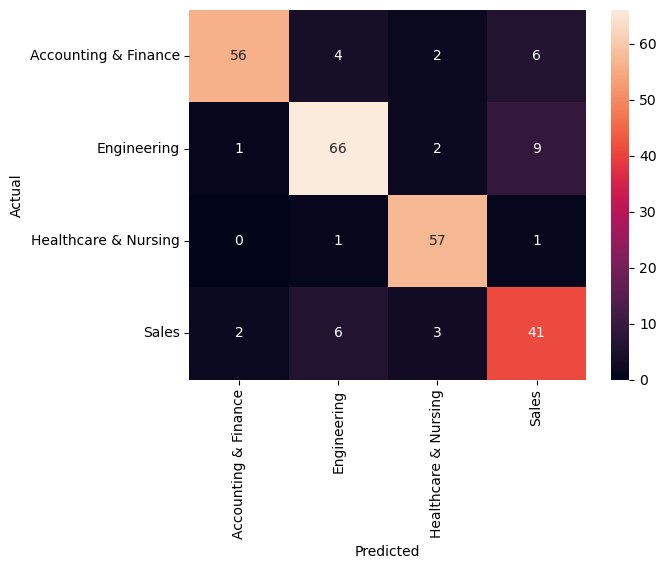

In [41]:
#I am plotting a heatmap to generate the confusion matrix
%matplotlib inline
jcategories = ['Accounting & Finance', 'Engineering', 'Healthcare & Nursing', 'Sales'] 
sns.heatmap(confusionmatrix, annot=True, fmt='d',
            xticklabels=jcategories, yticklabels=jcategories)

plt.ylabel('Actual')
plt.xlabel('Predicted')

In [42]:
#This is for unweighted vector
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(unweighted, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 4000, random_state=seed)
model.fit(X_train, y_train)
print("This is the model accuracy for Unweighted Vector:")
model.score(X_test, y_test)

'This is the model accuracy for Unweighted Vector:'


0.8443579766536965

In [43]:
#I am using the confusion matrix to evaluate the accuracy of the classification based on the model:
predictedlabel = model.predict(X_test)
confusionmatrix = confusion_matrix(y_test, predictedlabel)
confusionmatrix

array([[54,  3,  3,  8],
       [ 1, 67,  3,  7],
       [ 1,  1, 57,  0],
       [ 4,  7,  2, 39]])

Text(0.5, 23.52222222222222, 'Predicted')

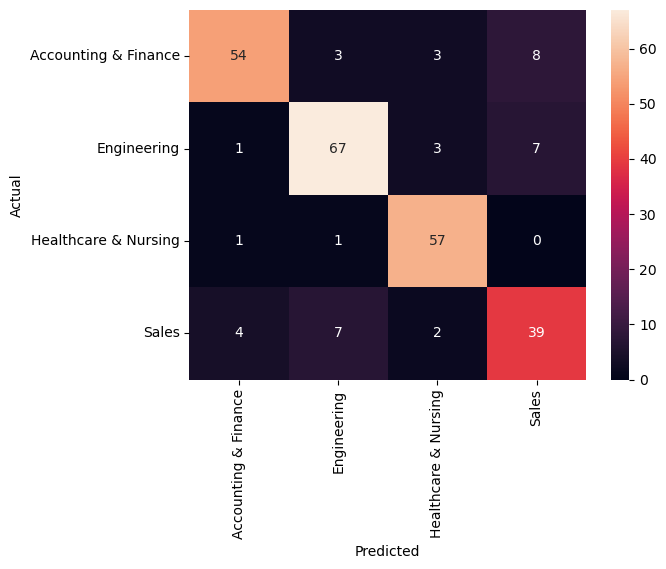

In [44]:
#I am plotting a heatmap to generate the confusion matrix
%matplotlib inline
jcategories = ['Accounting & Finance', 'Engineering', 'Healthcare & Nursing', 'Sales'] 
sns.heatmap(confusionmatrix, annot=True, fmt='d',
            xticklabels=jcategories, yticklabels=jcategories)

plt.ylabel('Actual')
plt.xlabel('Predicted')

### 5-Fold Cross Validation

In [45]:
#Performing 5-KFold:
num_folds = 5
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True) # initialise a 5 fold validation
print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


In [46]:
def evaluate(X_train,X_test,y_train, y_test,seed):
    model = LogisticRegression(random_state=seed,max_iter = 4000)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [47]:
num_models = 3
cv_df = pd.DataFrame(columns = ['count','unweighted','weighted'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(df['Category'])))):
    y_train = [str(df['Category'][i]) for i in train_index]
    y_test = [str(df['Category'][i]) for i in test_index]

    X_train_count, X_test_count = countfeatures[train_index], countfeatures[test_index]
    cv_df.loc[fold,'count'] = evaluate(countfeatures[train_index],countfeatures[test_index],y_train,y_test,seed)
    
    X_train_unweighted, X_test_unweighted = unweighted.iloc[train_index.tolist()], unweighted.iloc[test_index.tolist()]
    cv_df.loc[fold,'unweighted'] = evaluate(unweighted.iloc[train_index.tolist()],unweighted.iloc[test_index.tolist()],y_train,y_test,seed)

    X_train_weighted, X_test_weighted = weightedvectors[train_index], weightedvectors[test_index]
    cv_df.loc[fold,'weighted'] = evaluate(weightedvectors[train_index],weightedvectors[test_index],y_train,y_test,seed)
    
    fold +=1

In [48]:
#I am printing the dataframe generated from the k-fold cross validation
cv_df

count unweighted  weighted
0  0.852564   0.839744  0.833333
1  0.883871   0.851613  0.851613
2  0.890323   0.812903  0.812903
3  0.877419   0.812903   0.83871
4  0.916129   0.825806       0.8

In [49]:
#I am calculating the mean of the obtained vector
cv_df.mean()

count         0.884061
unweighted    0.828594
weighted      0.827312
dtype: float64

### Inference

- Among the three vectors I observed that the **count_vector** using the bag of words model provided the better accuracy result of 88.4% 
- **Weighted vector** provided an accuracy of 82.7%, whereas **Unweighted vector** provided an accuracy of 82.8% indicating that adding weights to the words did not provide a great deal of increase in the efficeny of the accuracy.


### Question 2

### Title Extraction and Tokenization

In [50]:
#I am extracting the title from the cleanedjob.txt and saving it in the list which I stored in the first task
def extract_titles(filename):
    titles = []
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("Title:"):
                title_end = line.find("Webindex:")  
                if title_end != -1:
                    title_only = line[len("Title:"):title_end].strip()
                else:
                    title_only = line[len("Title:"):].strip()  
                titles.append(title_only.lower())
    return titles

tt = extract_titles('cleanedjob.txt')
print(tt)

['finance / accounts asst bromley to ****k,',
 'fund accountant  hedge fund,',
 'deputy home manager,',
 'brokers wanted imediate start,',
 'rgn nurses (hospitals)  penarth,',
 'production coordinator,',
 'scrub nurse,',
 'sales & purchase ledger clerk  maternity cover,',
 'recruitment sales executive,',
 'business development executive  field sales  dartford,',
 'investments & treasury controller,',
 'european payroll,',
 'engineering assessor / instructor  south yorkshire,',
 'international account manager,',
 'senior production technologist (malaysia),',
 'insurance sales executive  horsham,',
 'vehicle purchaser / car sales,',
 'marine engines specialist – product support,',
 'sales manager/medical sales executive,',
 'optical assistant  oxfordshire,',
 'perm unit mgr rgn kid minster flexi ****k due,',
 "perm rgn's in bangor codown  f/t flexi  ****ph exopp  bangor,",
 'ecommerce country manager (netherlands),',
 'business development manager  leading financial lending plc,',
 'dyna

In [51]:
#I am checking the stats of the title values that is extracted from the file
def stats_print(tokenised_title):
    words = list(chain.from_iterable(tokenised_title))
    vocab = set(words)
    lexical_diversity = len(vocab) / len(words)
    print("Vocabulary size: " + str(len(vocab)))
    print("Total number of tokens: " + str(len(words)))
    print("Lexical diversity: " + str(lexical_diversity))
    print("Total number of titles: " + str(len(tokenised_title)))
    lens = [len(title) for title in tokenised_title]
    print("Average document length: " + str(np.mean(lens)))
    print("Maximum document length: " + str(np.max(lens)))
    print("Minimum document length: " + str(np.min(lens)))
    print("Standard deviation of document length: " + str(np.std(lens)))

In [52]:
stats_print(tt)

'Vocabulary size: 48'
'Total number of tokens: 25873'
'Lexical diversity: 0.001855215862095621'
'Total number of titles: 776'
'Average document length: 33.34149484536083'
'Maximum document length: 82'
'Minimum document length: 6'
'Standard deviation of document length: 14.01694960096357'


In [53]:
#I am defining a function to tokenize the description file:
def tokenizetitle(raw_title):
    
    #Segmenting the text into sentences
    sentences = sent_tokenize(raw_title)
    
    #tokenizing each sentence:
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
    
    tokenizer = RegexpTokenizer(pattern)
    tokenslist = [tokenizer.tokenize(s) for s in sentences]
    
    #I am merging them into a list of tokens:
    tokenizedtitle = list(chain.from_iterable(tokenslist))
    return tokenizedtitle

In [54]:
#I am storing the tokenized title using the list comprehension method.
tokenised_titles = [tokenizetitle(title) for title in tt]

In [55]:
tokenised_titles[0]

['finance', 'accounts', 'asst', 'bromley', 'to', 'k']

In [56]:
#I am removing single characters from the tokenized title.
tokenised_titles = [[w for w in desc if len(w) >= 2 ]\
                 for desc in tokenised_titles]

**I did not further tokenize the words in the title because there are already limited number of words in the vocabulary further tokenizing might remove a lot of words and might cause overfitting to the model's accuracy**

In [57]:
#This is the stats after tokenizing the title values.
stats_print(tokenised_titles)

'Vocabulary size: 985'
'Total number of tokens: 3077'
'Lexical diversity: 0.32011699707507313'
'Total number of titles: 776'
'Average document length: 3.9652061855670104'
'Maximum document length: 12'
'Minimum document length: 1'
'Standard deviation of document length: 1.7350467799519218'


In [58]:
#I am extracting the vector features using the pre-trained word2vec model.
titlefeature = docvectors(pretrained_wv,tokenised_titles)

In [59]:
#I am printing the matrix to check if the values are getting printed properly.
titlefeature

0         1         2         3         4         5         6    \
0    0.225891  0.257324  0.492035 -0.115906 -0.143066  0.049423 -0.051758   
1    0.503418 -0.057098  0.308105 -0.115234  0.238892 -0.142822  0.163528   
2   -0.208862 -0.161865 -0.023926 -0.732422 -0.125488 -0.004150  0.479614   
3    0.138428  0.437988  0.063599  0.052734 -0.298340 -0.606445  0.114014   
4   -0.148193 -0.062012  0.395020  0.438477  0.075684 -0.055267 -0.244141   
..        ...       ...       ...       ...       ...       ...       ...   
771  0.149170 -0.217773  0.311768 -0.054932 -0.231689 -0.378662 -0.089691   
772 -0.110352 -0.038574  0.212585  0.426025 -0.331543 -0.082520  0.075256   
773  0.208008 -0.396973 -0.188293 -0.004150 -0.076050  0.226074  0.450317   
774 -0.290527 -0.677734 -0.466309  0.231201 -0.553955  0.556152  0.024658   
775  0.028320 -0.187988  0.014160 -0.410645  0.055176 -0.489746  0.200562   

          7         8         9    ...       290       291       292  \
0   -0.718994  0.718262 -0.101562  ... -0.128906 -0.126221  0.049683   
1   -0.595337  0.884766 -0.633789  ... -0.156433  0.814575 -0.610840   
2   -0.550293  0.168457  0.131104  ... -0.219727  0.356689  0.090332   
3   -0.226074  0.101074  0.254364  ... -0.105820  0.383057 -0.513245   
4   -0.112793  0.116028 -0.128662  ... -0.378906 -0.289062 -0.744141   
..        ...       ...       ...  ...       ...       ...       ...   
771 -0.663069  0.289673  0.906738  ...  0.289322  0.399475 -0.936523   
772 -0.669922 -0.074097  0.335205  ... -0.373047  0.315674 -0.132324   
773 -0.562500 -0.252563 -0.133057  ...  0.082489  0.316162 -0.473145   
774 -0.477539 -0.450684 -0.276978  ... -0.441406  0.312790 -0.481079   
775 -0.532227  0.012939  0.443115  ...  0.186127  0.424072 -0.546875   

          293       294       295       296       297       298       299  
0   -0.342285 -0.375732 -0.682129  0.061523 -0.231720 -0.117188  0.503906  
1    0.111572 -0.260254 -0.132324  0.001953  0.140137 -0.308105 -0.035095  
2    0.121277 -0.097046 -0.116821  0.337280 -0.396240  0.448730  0.296021  
3    0.379883  0.023193  0.099823  0.162109 -0.105469 -0.065430 -0.212158  
4    0.093262 -0.082031  0.418457 -0.134277  0.020996  0.273926  0.208496  
..        ...       ...       ...       ...       ...       ...       ...  
771  0.393934  0.423340  0.362019  0.538208  0.018555  0.533569 -0.603760  
772  0.424866 -0.177490 -0.091705 -0.539307  0.001953 -0.136749 -0.402344  
773  0.585938 -0.040405  0.155273  0.703125 -0.005371  0.913086  0.249512  
774 -0.071045  0.330566  0.134644 -0.124023 -0.071167  0.308960  0.199585  
775  0.317627  0.163086  0.111328  0.599121 -0.166504  0.413574 -0.165527  

[776 rows x 300 columns]

In [60]:
#I am checking if there are any null values present in the vectors generated.
titlefeature.isna().any().sum() 

0

#### Accuracy of Title Only

In [61]:
#I am checking the accuracy of only the title
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(titlefeature, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 4000, random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8287937743190662

#### Accuracy of Description Only

In [62]:
#Checking the accuracy of description only again
#This is for unweighted vector
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(unweighted, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 4000, random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8443579766536965

#### Accuracy of Title and Description Together

In [63]:
#I have combined the vectors of description and title and I am checking the accuracy of the model.
combinedvector = np.hstack((unweighted, titlefeature))

In [64]:
combinedvector

array([[ 7.52700806e-01,  1.53520203e+00, -9.59762573e-01, ...,
        -2.31719971e-01, -1.17187500e-01,  5.03906250e-01],
       [ 2.09289551e-01,  1.93817139e+00,  2.12295532e+00, ...,
         1.40136719e-01, -3.08105469e-01, -3.50952148e-02],
       [-4.97357178e+00, -1.25425339e-01,  3.94592285e-02, ...,
        -3.96240234e-01,  4.48730469e-01,  2.96020508e-01],
       ...,
       [-1.22290850e+01,  1.10711288e+01, -6.65078735e+00, ...,
        -5.37109375e-03,  9.13085938e-01,  2.49511719e-01],
       [-2.31051636e+00,  3.10843658e+00, -3.53460693e+00, ...,
        -7.11669922e-02,  3.08959961e-01,  1.99584961e-01],
       [-2.03363037e+00,  2.57100487e+00, -1.31686401e+00, ...,
        -1.66503906e-01,  4.13574219e-01, -1.65527344e-01]])

In [65]:
#This is the logistic regression model for both the vectors.
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(combinedvector, df['Category'], list(range(0,len(df))), test_size = 0.33, random_state= seed)
model = LogisticRegression(max_iter = 4000, random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8638132295719845

### Inference
**Among the three vectors I observed that while using both title and description provided better accuracy of 86.3% because the model had a increased information which allowed it to make more accurate information by considering both the information provided, compared two individual values of title which has a accuracy of 82.87% and description with the value of 84.4%**

## Summary
The second task shed light on how to handle large data, that are present in different categories and collabrating it into one, the overall construction of the task helped me understand the pre-processing that is required to do when we are handling text based scenarios, I sincerly want to thank all the teachers involved in teaching us to be better.

## References
RMIT (no date) Week7, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/week-7-lecture?module_item_id=5855618 (Accessed: 09 May 2024). 

RMIT (no date) Week7 Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/files/35809644?module_item_id=5855619 (Accessed: 10 May 2024). 

RMIT (no date a) Week7-Activity, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/activity-2-basic-text-processing-with-nltk-part-2?module_item_id=5855624 (Accessed: 12 May 2024). 

RMIT (no date) Week8 Lab, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/week-8-lab?module_item_id=5855630 (Accessed: 13 May 2024). 

RMIT (no date) Week8 Activity3, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/activity-3-generate-feature-vectors?module_item_id=5855638 (Accessed: 13 May 2024).

RMIT (no date) Week8 Activity4, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/activity-4-document-classification?module_item_id=5855639(Accessed: 13 May 2024).

RMIT (no date) Week9 Activity6, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/activity-6-document-classification-with-embeddings?module_item_id=5855651(Accessed: 14 May 2024).

RMIT (no date) Week9, Rmit.instructure.com. Available at: https://rmit.instructure.com/courses/134429/pages/week-9-activities?module_item_id=5855641(Accessed: 14 May 2024).